<center>
<img src="../../img/ods_stickers.jpg" />
    
## [mlcourse.ai](https://mlcourse.ai) – Open Machine Learning Course 
Author: [Yury Kashnitsky](https://yorko.github.io) (@yorko). Edited by Anna Tarelina (@feuerengel), and Mikhail Korshchikov (@MS4). This material is subject to the terms and conditions of the [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) license. Free use is permitted for any non-commercial purpose.

# <center>Assignment #2. Fall 2019
## <center> Part 1. Decision trees for classification and regression

**In this assignment, we will find out how a decision tree works in a regression task, then will build and tune classification decision trees for identifying heart diseases.**

Prior to working on the assignment, you'd better check out the corresponding course material:
 1. [Classification, Decision Trees and k Nearest Neighbors](https://nbviewer.jupyter.org/github/Yorko/mlcourse_open/blob/master/jupyter_english/topic03_decision_trees_kNN/topic3_decision_trees_kNN.ipynb?flush_cache=true), the same as an interactive web-based [Kaggle Kernel](https://www.kaggle.com/kashnitsky/topic-3-decision-trees-and-knn) 
 2. Ensembles:
  - [Bagging](https://nbviewer.jupyter.org/github/Yorko/mlcourse_open/blob/master/jupyter_english/topic05_ensembles_random_forests/topic5_part1_bagging.ipynb?flush_cache=true), the same as a [Kaggle Kernel](https://www.kaggle.com/kashnitsky/topic-5-ensembles-part-1-bagging)
  - [Random Forest](https://nbviewer.jupyter.org/github/Yorko/mlcourse_open/blob/master/jupyter_english/topic05_ensembles_random_forests/topic5_part2_random_forest.ipynb?flush_cache=true), the same as a [Kaggle Kernel](https://www.kaggle.com/kashnitsky/topic-5-ensembles-part-2-random-forest)
  - [Feature Importance](https://nbviewer.jupyter.org/github/Yorko/mlcourse_open/blob/master/jupyter_english/topic05_ensembles_random_forests/topic5_part3_feature_importance.ipynb?flush_cache=true), the same as a [Kaggle Kernel](https://www.kaggle.com/kashnitsky/topic-5-ensembles-part-3-feature-importance)
 3. - [Gradient boosting](https://nbviewer.jupyter.org/github/Yorko/mlcourse_open/blob/master/jupyter_english/topic10_boosting/topic10_gradient_boosting.ipynb?flush_cache=true), the same as a [Kaggle Kernel](https://www.kaggle.com/kashnitsky/topic-10-gradient-boosting) 
   - Logistic regression, Random Forest, and LightGBM in the "Kaggle Forest Cover Type Prediction" competition: [Kernel](https://www.kaggle.com/kashnitsky/topic-10-practice-with-logit-rf-and-lightgbm) 
 4. You can also practice with demo assignments, which are simpler and already shared with solutions:
  - "Decision trees with a toy task and the UCI Adult dataset": [assignment](https://www.kaggle.com/kashnitsky/a3-demo-decision-trees) + [solution](https://www.kaggle.com/kashnitsky/a3-demo-decision-trees-solution)
  - "Logistic Regression and Random Forest in the credit scoring problem": [assignment](https://www.kaggle.com/kashnitsky/assignment-5-logit-and-rf-for-credit-scoring) + [solution](https://www.kaggle.com/kashnitsky/a5-demo-logit-and-rf-for-credit-scoring-sol)
 5. There are also 7 video lectures on trees, forests, boosting and their applications: [mlcourse.ai/lectures](https://mlcourse.ai/lectures) 

### Your task is to:
 1. write code and perform computations in the cells below
 2. choose answers in the [webform](https://docs.google.com/forms/d/1-xvxl0xjV4voDYIbcCxxpAc_pjcWEpnLQ9kaKLHwXsA). Solutions will be shared only with those who've filled in this form 
 
### <center> Deadline for A2: 2019 October 6, 20:59 CET (London time)

In [1]:
import numpy as np
import pandas as pd
import pydotplus
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz

## 1. Decision trees for regression: a toy example

Let's consider the following one-dimensional regression problem. We need to build a function $\large a(x)$ to approximate the dependency $\large y = f(x)$ using the mean-squared error criterion: $\large \min \sum_i {(a(x_i) - f(x_i))}^2$.

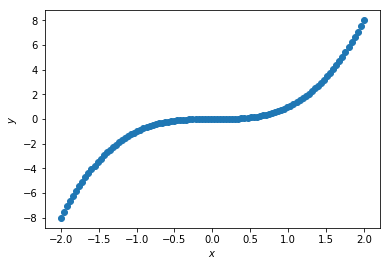

In [170]:
X = np.linspace(-2, 2, 100)
y = X ** 3 # original dependecy 

plt.scatter(X, y)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

Let's make several steps to build a decision tree. In the case of a **regression** task, at prediction time, the leaf returns the average value for all observations in this leaf.

Let's start with a tree of depth 0, i.e. all observations placed in a single leaf. 

<br>You'll need to build a tree with only one node (also called **root**) that contains all train observations (instances). 
<br>How will predictions of this tree look like for $x \in [-2, 2]$? <br> Create an appropriate plot using a pen, paper and Python if needed (but no `sklearn` is needed yet).

**Making first splits.**
<br>Let's split the data according to the following condition $[x < 0]$. It gives us the tree of depth 1 with two leaves. To clarify, for all instances with $x \geqslant 0$ the tree will return some value, for all instances with $x < 0$ it will return another value. Let's create a similar plot for predictions of this tree.

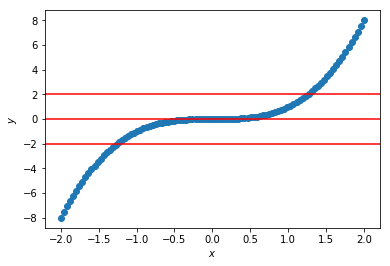

In [171]:
y0 = np.mean(y)
y1 = np.mean(y[X<0])
y2 = np.mean(y[X>=0])

plt.scatter(X, y)
plt.axhline(y=y0, color='r', linestyle='-')
plt.axhline(y=y1, color='r', linestyle='-')
plt.axhline(y=y2, color='r', linestyle='-')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

In the decision tree algorithm, the feature and the threshold for splitting are chosen according to some criterion. The commonly used criterion for regression is based on variance: $$\large Q(X, y, j, t) = D(X, y) - \dfrac{|X_l|}{|X|} D(X_l, y_l) - \dfrac{|X_r|}{|X|} D(X_r, y_r),$$
where $\large X$ and $\large y$ are a feature matrix and a target vector (correspondingly) for training instances in a current node, $\large X_l, y_l$ and $\large X_r, y_r$ are splits of samples $\large X, y$ into two parts w.r.t. $\large [x_j < t]$ (by $\large j$-th feature and threshold $\large t$), $\large |X|$, $\large |X_l|$, $\large |X_r|$ (or, the same, $\large |y|$, $\large |y_l|$, $\large |y_r|$) are sizes of appropriate samples, and $\large D(X, y)$ is variance of answers $\large y$ for all instances in $\large X$:
$$\large D(X, y) = \dfrac{1}{|X|} \sum_{j=1}^{|X|}(y_j – \dfrac{1}{|X|}\sum_{i = 1}^{|X|}y_i)^2$$
Here $\large y_i = y(x_i)$ is the answer for the $\large x_i$ instance. Feature index $\large j$ and threshold $\large t$ are chosen to maximize the value of criterion  $\large Q(X, y, j, t)$ for each split.

In our 1D case,  there's only one feature so $\large Q$ depends only on threshold $\large t$ and training data $\large X$ and $\large y$. Let's designate it $\large Q_{1d}(X, y, t)$ meaning that the criterion no longer depends on feature index $\large j$, i.e. in 1D case $\large j = 1$.

In [172]:
def d(y):
    return np.var(y)


def q(X, y, t):
    left_X = X[X<t]
    right_X = X[X>=t]
    
    original_D = d(y)
    left_D = d(y[X<t])
    right_D = d(y[X>=t])
        
    return original_D - len(left_X)/len(X) * left_D - len(right_X)/len(X) * right_D
    

Create the plot of criterion $\large Q_{1d}(X, y, t)$  as a function of threshold value $t$ on the interval $\large [-1.9, 1.9]$.

In [173]:
def tree(X, y, t):
    result = y.copy()
    result[X<t] = np.mean(y[X<t])
    result[X>=t] = np.mean(y[X>=t])
    return result

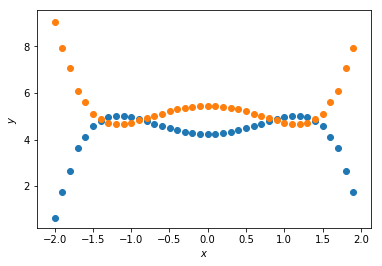

In [174]:
from sklearn.metrics import mean_squared_error
trange = np.arange(-1.999, 1.999, 0.1)
result = [q(X, y, t) for t in trange]
mse = [mean_squared_error(y, tree(X, y, t)) for t in trange]
plt.scatter(trange, result)
plt.scatter(trange, mse)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

**<font color='red'>Question 1.</font> What is the worst threshold value (to perform a split) according to the variance criterion?**

<font color = 'red'> **Answer options:** </font>
- -1.9
- -1.3
- 0 *
- 1.3
- 1.9 

*For discussions, please stick to [ODS Slack](https://opendatascience.slack.com/), channel __#mlcourse_ai_news__, pinned thread __#a2_part1_fall2019__*

Then let's make splitting in each of the leaves nodes. 
<br> Take your tree with first threshold [$x<0$].
<br> Now add a split in the left branch (where previous split was $x < 0$) using the criterion $[x < -1.5]$, in the right branch (where previous split was $x \geqslant 0$) with the following criterion $[x < 1.5]$. 
<br>It gives us a tree of depth 2 with 7 nodes and 4 leaves. Create a plot of this tree predictions for $x \in [-2, 2]$.

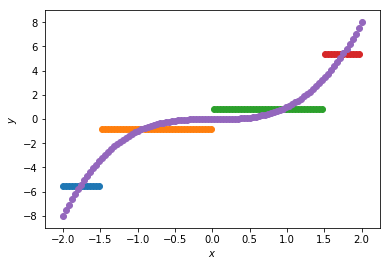

In [185]:
def pcf(X, y, a, b):
    mask = (X>=a) & (X<b)
    plt.scatter(X[mask], [np.mean(y[mask])]*len(y[mask]))
    return result

pcf(X, y, -2, -1.5)
pcf(X, y, -1.5, 0)
pcf(X, y, 0, 1.5)
pcf(X, y, 1.5, 2)
plt.scatter(X, y)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

**<font color='red'>Question 2.</font> Tree predictions is a piecewise-constant function, right? How many "pieces" (horizontal segments in the plot that you've just built) are there in the interval [-2, 2]?**

<font color = 'red'> **Answer options:** </font>
- 2
- 4 *
- 6
- 8

*For discussions, please stick to [ODS Slack](https://opendatascience.slack.com/), channel __#mlcourse_ai_news__, pinned thread __#a2_part1_fall2019__*

## 2. Building a decision tree for predicting heart diseases
Let's read the data on heart diseases. The dataset can be downloaded from the course repo from [here](https://github.com/Yorko/mlcourse.ai/blob/master/data/mlbootcamp5_train.csv) by clicking on `Download` and then selecting `Save As` option. If you work with Git, then the dataset is already there in `data/mlbootcamp5_train.csv`.

**Problem**

Predict presence or absence of cardiovascular disease (CVD) using the patient examination results.

**Data description**

There are 3 types of input features:

- *Objective*: factual information;
- *Examination*: results of medical examination;
- *Subjective*: information given by the patient.

| Feature | Variable Type | Variable      | Value Type |
|---------|--------------|---------------|------------|
| Age | Objective Feature | age | int (days) |
| Height | Objective Feature | height | int (cm) |
| Weight | Objective Feature | weight | float (kg) |
| Gender | Objective Feature | gender | categorical code |
| Systolic blood pressure | Examination Feature | ap_hi | int |
| Diastolic blood pressure | Examination Feature | ap_lo | int |
| Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |
| Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |
| Smoking | Subjective Feature | smoke | binary |
| Alcohol intake | Subjective Feature | alco | binary |
| Physical activity | Subjective Feature | active | binary |
| Presence or absence of cardiovascular disease | Target Variable | cardio | binary |

All of the dataset values were collected at the moment of medical examination.

In [123]:
df = pd.read_csv('../../data/mlbootcamp5_train.csv', 
                 index_col='id', sep=';')

In [124]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


Transform the features: 
- create "age in years" dividing age by 365.25 and taking floor ($\lfloor{x}\rfloor$ is the largest integer that is less than or equal to $x$) 
- create 3 binary features based on `cholesterol`.
- create 3 binary features based on `gluc`.
<br> Binary features equal to 1, 2 or 3. This method is called dummy-encoding or One Hot Encoding (OHE). It is more convenient to use `pandas.get_dummies`. There is no need to use the original features `cholesterol` and `gluc` after encoding.

In [125]:
df['age_years'] = np.floor(df['age'] / 365.25)

In [126]:
df = pd.get_dummies(df,columns=['cholesterol', 'gluc'])

In [127]:
X = df.drop(['cardio'], axis=1)
y = df['cardio']
print(X.shape)
print(y.shape)

(70000, 16)
(70000,)


In [128]:
X.head()

,age,gender,height,weight,ap_hi,ap_lo,smoke,alco,active,age_years,cholesterol_1,cholesterol_2,cholesterol_3,gluc_1,gluc_2,gluc_3
id,,,,,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,0,0,1,50.0,1,0,0,1,0,0
1,20228,1,156,85.0,140,90,0,0,1,55.0,0,0,1,1,0,0
2,18857,1,165,64.0,130,70,0,0,0,51.0,0,0,1,1,0,0
3,17623,2,169,82.0,150,100,0,0,1,48.0,1,0,0,1,0,0
4,17474,1,156,56.0,100,60,0,0,0,47.0,1,0,0,1,0,0


In [129]:
feature_names = list(X.columns)

Split data into train and holdout parts in the proportion of 7/3 using `sklearn.model_selection.train_test_split` with `random_state=17`.

In [130]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.7, shuffle=True, random_state=17)

Train a decision tree on the dataset `(X_train, y_train)` with **max depth equal to 3** and `random_state=17`. Plot this tree with `sklearn.tree.export_graphviz` and Graphviz. Here we need to mention that `sklearn` doesn't draw decision trees on its own, but is able to output a tree in the `.dot` format that can be used by Graphviz for visualization. 

How to plot a decision tree, alternatives:
 1. Install Graphviz and pydotpus yourself (see below)
 2. Use our docker image with all needed packages already installed
 3. Easy way: execute `print(dot_data.getvalue())` with `dot_data` defined below (this can be done without pydotplus and Graphviz), go to http://www.webgraphviz.com, paste the graph code string (digraph Tree {...) and generate a nice picture

There are may be some troubles with graphviz for Windows users.
The error is 'GraphViz's executables not found'.
<br>To fix that - install Graphviz from [here](https://graphviz.gitlab.io/_pages/Download/Download_windows.html).
<br>Then add graphviz path to your system PATH variable. You can do this manually, but don't forget to restart kernel.
<br>Or just run this code:

In [131]:
from IPython.display import Image
def get_graph(tree, feature_names):
    tree_str = export_graphviz(tree, feature_names=feature_names, 
                                     filled=True, out_file=None)
    graph = pydotplus.graph_from_dot_data(tree_str) 
    return graph

In [132]:
dtc = DecisionTreeClassifier(max_depth=3, random_state=17)
dtc.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=17, splitter='best')

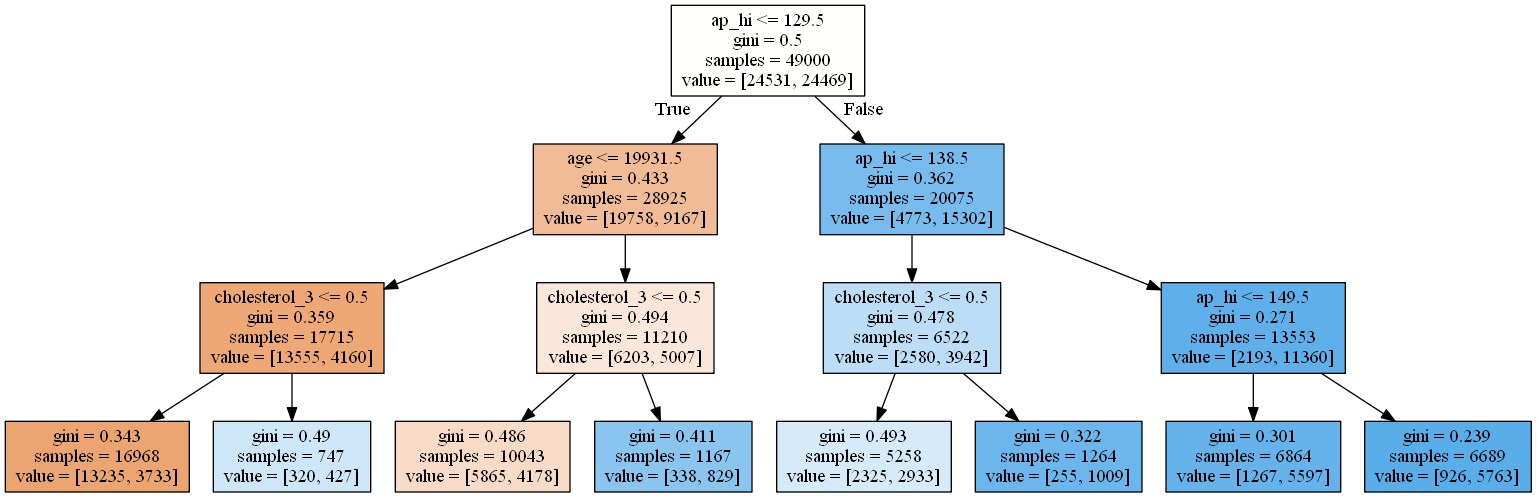

In [133]:
graph = get_graph(dtc, feature_names)
Image(graph.create_png())

Take a look how trees are visualized in the [3rd part](https://nbviewer.jupyter.org/github/Yorko/mlcourse_open/blob/master/jupyter_english/topic03_decision_trees_kNN/topic3_decision_trees_kNN.ipynb?flush_cache=true) of course materials.

**<font color='red'>Question 3.</font> Which 3 features are used to make predictions in the created decision tree?**

<font color = 'red'> **Answer options:** </font>
- age, ap_lo, chol=1
- age, ap_hi, chol=3 *
- smoke, age, gender
- alco, weight, gluc=3

*For discussions, please stick to [ODS Slack](https://opendatascience.slack.com/), channel __#mlcourse_ai_news__, pinned thread __#a2_part1_fall2019__*

Make predictions for holdout data `(X_valid, y_valid)` with the trained decision tree. Calculate accuracy.

In [134]:
predicted_3 = dtc.predict(X_valid)
accuracy_3 = accuracy_score(y_valid, predicted_3)
accuracy_3

0.7212857142857143

Set up the depth of the tree using cross-validation on the dataset `(X_train, y_train)` in order to increase quality of the model. Use `GridSearchCV` with 5 folds. Fix `random_state=17` and change  `max_depth` from 2 to 10.

In [135]:
tree_params = {'max_depth': list(range(2, 11))}

tree_grid = GridSearchCV(dtc, param_grid=tree_params, scoring='accuracy', n_jobs=-1, cv=5, verbose=1)
tree_grid.fit(X_train, y_train)

predict = tree_grid.predict(X_valid)
print(accuracy_score(y_valid, predict))

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


0.7258095238095238


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   10.1s finished


Draw the plot to show how mean accuracy is changing in regards to `max_depth` value on cross-validation.

In [136]:
print(tree_grid.best_params_)
print(tree_grid.best_score_)

{'max_depth': 6}
0.7319591836734693


[0.72604836 0.7277551  0.73744898 0.73020408 0.73834065]


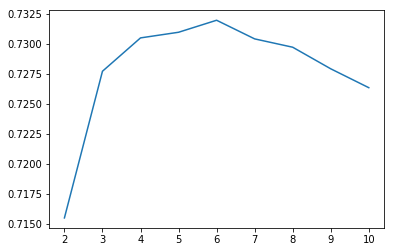

In [137]:
accuracy = np.asarray([tree_grid.cv_results_['split{}_test_score'.format(x)] for x in range(5)])
print(accuracy[:, 4])
plt.plot(tree_params['max_depth'], np.mean(accuracy, axis=0))

Print the best value of `max_depth` where the mean value of cross-validation quality metric reaches maximum. Also compute accuracy on holdout data. This can be done with the trained instance of the class `GridSearchCV`.

In [141]:
predicted_6 = tree_grid.predict(X_valid)
accuracy_6 = accuracy_score(y_valid, predicted_6)
accuracy_6

0.7258095238095238

Сalculate the effect of `GridSearchCV`: check out the expression (acc2 - acc1) / acc1 * 100%, where acc1 and acc2 are accuracies on holdout data before and after tuning max_depth with GridSearchCV respectively.

In [139]:
(accuracy_6 - accuracy_3) / accuracy_3 * 100

0.6271869016967002

**<font color='red'>Question 4.</font> Choose all correct statements.**

<font color = 'red'> **Answer options:** </font>

- There exists a local maximum of accuracy on the built validation curve *
- `GridSearchCV` increased holdout accuracy by **more** than 1%
- There is **no** local maximum of accuracy on the built validation curve
- `GridSearchCV` increased holdout accuracy by **less** than 1% *

*For discussions, please stick to [ODS Slack](https://opendatascience.slack.com/), channel __#mlcourse_ai_news__, pinned thread __#a2_part1_fall2019__*

Take a look at the SCORE table to estimate ten-year risk of fatal cardiovascular disease in Europe. [Source paper](https://academic.oup.com/eurheartj/article/24/11/987/427645).

<img src='../../img/SCORE2007-eng.png' width=70%>

Let's create new features according to this picture:
- $age \in [40,50), age \in [50,55), age \in [55,60), age \in [60,65) $ (4 features)
- systolic blood pressure: $ap\_hi \in [120,140), ap\_hi \in [140,160), ap\_hi \in [160,180),$ (3 features)

If the values of age or blood pressure don't fall into any of the intervals then all binary features will be equal to zero. 

<br>Add a ``smoke`` feature.
<br>Build the ``cholesterol``  and ``gender`` features. Transform the ``cholesterol`` to 3 binary features according to it's 3 unique values ( ``cholesterol``=1,  ``cholesterol``=2 and  ``cholesterol``=3). Transform the ``gender`` from 1 and 2 into 0 and 1. It is better to rename it to ``male`` (0 – woman, 1 – man). In general, this is typically done with ``sklearn.preprocessing.LabelEncoder`` but here in case of only 2 unique values it's not necessary.

Finally, the decision tree is built using these 12 binary features (excluding all original features that we had before this feature engineering part).

Create a decision tree with the limitation `max_depth=3` and train it on the whole train data. Use the `DecisionTreeClassifier` class with fixed `random_state=17`, but all other arguments (except for `max_depth` and `random_state`) should be left with their default values.

**<font color='red'>Question 5.</font> Which binary feature is the most important for heart disease detection (i.e., it is placed in the root of the tree)?**

<font color = 'red'> **Answer options:** </font>

- Systolic blood pressure from 160 to 180 (mmHg)
- Cholesterol level == 3
- Systolic blood pressure from 140 to 160 (mmHg) *
- Age from 50 to 55 (years)
- Smokes / doesn't smoke
- Age from 60 to 65 (years)

*For discussions, please stick to [ODS Slack](https://opendatascience.slack.com/), channel __#mlcourse_ai_news__, pinned thread __#a2_part1_fall2019__*

In [237]:
df = pd.read_csv('../../data/mlbootcamp5_train.csv', 
                 index_col='id', sep=';')
df2 = df[['cholesterol', 'smoke', 'gender', 'age', 'ap_hi']]
df2.loc[:, 'age'] = df2['age'].apply(lambda x: np.floor(x / 365.25))
df2 = df2.rename(columns={'gender': 'male'})
df2.loc[:, 'male'] -= 1

bins = [40, 50, 55, 60, 65]
labels=['40-50', '50-55', '55-60', '60-65']
df2['age']= pd.cut(df2['age'], bins, right=False)

bins = [120, 140, 160, 180]
df2['ap_hi']= pd.cut(df2['ap_hi'], bins, right=False)

df2 = pd.get_dummies(df2,columns=['cholesterol', 'age', 'ap_hi'])
df2.head()

,smoke,male,cholesterol_1,cholesterol_2,cholesterol_3,"age_[40, 50)","age_[50, 55)","age_[55, 60)","age_[60, 65)","ap_hi_[120, 140)","ap_hi_[140, 160)","ap_hi_[160, 180)"
id,,,,,,,,,,,,
0,0,1,1,0,0,0,1,0,0,0,0,0
1,0,0,0,0,1,0,0,1,0,0,1,0
2,0,0,0,0,1,0,1,0,0,1,0,0
3,0,1,1,0,0,1,0,0,0,0,1,0
4,0,0,1,0,0,1,0,0,0,0,0,0


In [238]:
X = df2
y = df['cardio']
print(X.shape)
print(y.shape)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.7, shuffle=True, random_state=17)

(70000, 12)
(70000,)


In [239]:
feature_names = list(X.columns)

In [245]:
dtc = DecisionTreeClassifier(max_depth=3, random_state=17)
dtc.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=17, splitter='best')

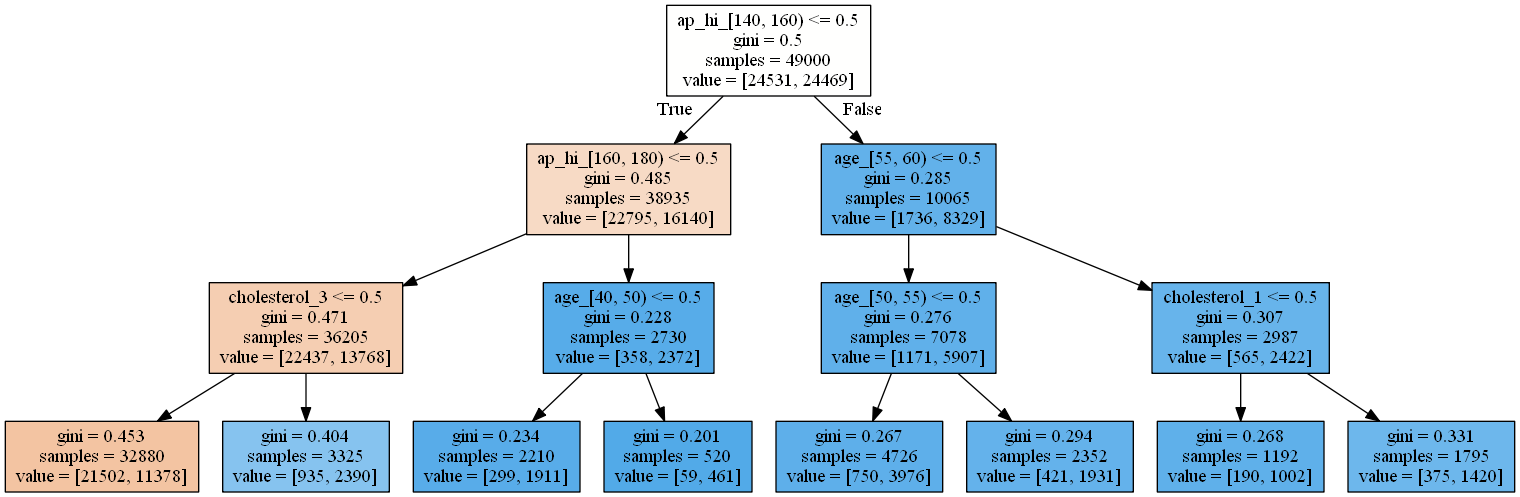

In [244]:
graph = get_graph(dtc, feature_names)
Image(graph.create_png())

In [246]:
predicted = dtc.predict(X_valid)
accuracy_score(y_valid, predicted)

0.704047619047619